In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import copy
from torch import nn
from torch.utils import data
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from omegaconf import OmegaConf, DictConfig
from ml_utilities.torch_models import get_model_class
from ml_utilities.torch_utils import gradients_to_vector
from erank.data.datasetgenerator import DatasetGenerator
from erank.gradients import GradientCalculator, magnitude_prune_vectors, intersectionOverUnion
from erank.analyses import create_model_erank_df
from erank.plot import plot_models_erank
import matplotlib.pyplot as plt
gpu_id = 3

## 12.1.1 Local Gradient Experiment
We compute local gradients of a model pretrained for `pretrain_steps` on rotation 0° with mnist rotated with `rotation_angle`.

We use Lenet and rotated MNIST in this experiment.

In [2]:
pretrain_steps = 50
rotation_angle = 45

## Setup

In [3]:
cfg = f"""
dataset_generator_kwargs:
  dataset: rotatedvision
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data #/home/max/phd/data 
    dataset: mnist
    rotation_angle: {rotation_angle}
  dataset_split:
    train_val_split: 0.8

run_path: /system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.5.0-lenet--221015_122552
model_idx: {pretrain_steps}
default_loss: crossentropy
device: {gpu_id}
"""
cfg = OmegaConf.create(cfg)

In [4]:
gradient_calculator = GradientCalculator(**cfg)

In [9]:
# create gradients bs dict
# batch_sizes = [128, 32, 8]
batch_sizes = [2048, 1024, 512, 256]
grad_bs_dict = {}
for bs in batch_sizes:
    grad_bs_dict[bs] = torch.stack(gradient_calculator.compute_gradients(batch_size=bs))

100%|██████████| 188/188 [00:14<00:00, 12.74it/s]


## Gradient histograms

In [7]:
gradients = gradient_calculator.compute_gradients(batch_size=128)

100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


In [8]:
gs = torch.stack(gradients)

In [27]:
mean_grad = gs.mean(dim=0)
mean_abs_grad = mean_grad.abs()
mean_abs_grad.max(), mean_abs_grad.mean(), mean_abs_grad.median(), mean_abs_grad.std()

(tensor(0.0980, device='cuda:0'),
 tensor(0.0016, device='cuda:0'),
 tensor(0.0010, device='cuda:0'),
 tensor(0.0022, device='cuda:0'))

(array([1.3988e+04, 1.2591e+04, 1.1038e+04, 9.4320e+03, 8.2630e+03,
        7.2120e+03, 6.0090e+03, 5.4640e+03, 4.9230e+03, 4.2150e+03,
        3.6200e+03, 3.2530e+03, 2.8690e+03, 2.4620e+03, 2.0810e+03,
        1.9700e+03, 1.6770e+03, 1.3700e+03, 1.2060e+03, 9.8800e+02,
        9.6000e+02, 8.0600e+02, 6.6000e+02, 6.4400e+02, 4.7800e+02,
        4.4000e+02, 3.9000e+02, 3.4700e+02, 2.7400e+02, 2.6100e+02,
        2.3800e+02, 2.0900e+02, 1.7900e+02, 1.5800e+02, 1.2600e+02,
        1.2600e+02, 1.1000e+02, 1.3300e+02, 8.8000e+01, 7.3000e+01,
        6.4000e+01, 6.6000e+01, 5.1000e+01, 5.7000e+01, 5.9000e+01,
        4.3000e+01, 4.0000e+01, 5.0000e+01, 4.0000e+01, 3.1000e+01,
        3.1000e+01, 2.1000e+01, 3.0000e+01, 2.1000e+01, 2.3000e+01,
        1.9000e+01, 2.4000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        1.9000e+01, 2.2000e+01, 2.0000e+01, 1.8000e+01, 1.5000e+01,
        1.2000e+01, 1.0000e+01, 1.1000e+01, 1.5000e+01, 8.0000e+00,
        8.0000e+00, 1.1000e+01, 1.9000e+01, 1.10

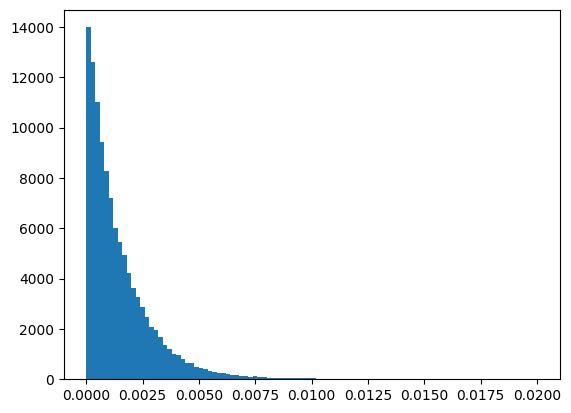

In [32]:
plt.hist(mean_abs_grad.cpu().numpy(), range=(0, 0.02), bins=100)

In [49]:
std = mean_grad.std().item()
r = 3

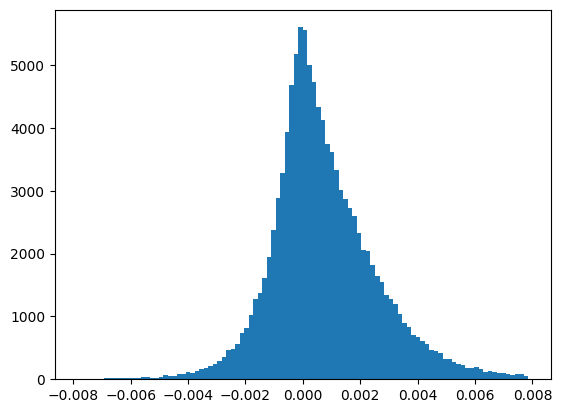

In [50]:
f = plt.hist(mean_grad.cpu().numpy(), bins=100, range=(-r*std, r*std))

In [46]:
med_vals, med_idxs = gs.median(dim=0)

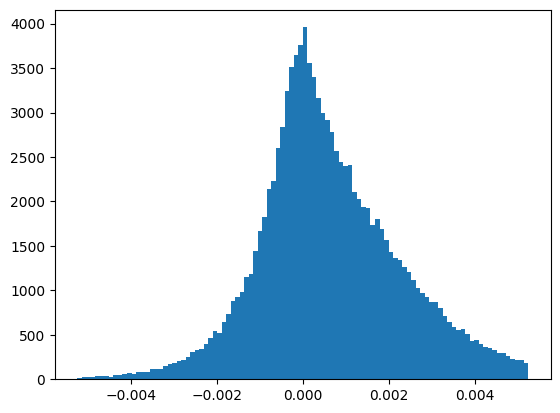

In [47]:
f = plt.hist(med_vals.cpu().numpy(), bins=100, range=(-r*std, r*std))


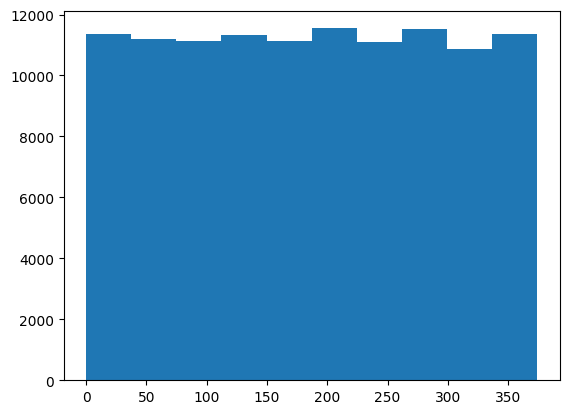

In [48]:
f = plt.hist(med_idxs.cpu().numpy())

## Gradient Erank Plots

In [8]:
erank_df = create_model_erank_df(grad_bs_dict, device=gpu_id)

Calculate eranks: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]


In [9]:
erank_df

,128,32,8,Gaussian random
Number of Vectors,,,,
1,1.000000,1.000000,1.000000,1.000000
11,8.061534,9.083018,10.024196,10.999938
21,13.156454,15.995507,17.360422,20.999805
31,18.178844,22.160236,23.509106,30.999548
41,22.756889,28.111721,29.756655,40.999218
51,27.084934,33.149498,36.301804,50.998711
61,31.228952,37.993004,41.434837,60.998215
71,35.405457,43.079273,47.123589,70.997536
81,39.307163,48.131790,52.291225,80.996841


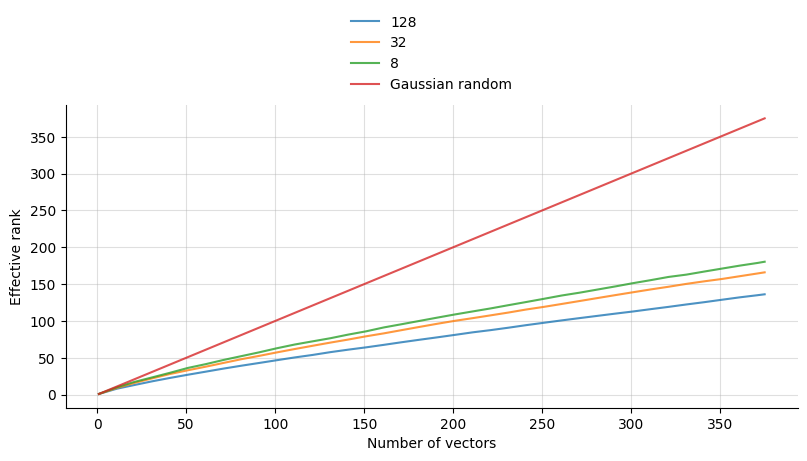

In [10]:
# erank of gradients for different batch sizes
f = plot_models_erank(erank_df=erank_df)

In [ ]:
# smaller batch size has higher erank -> Explanation: more gradient noise

Calculate eranks: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


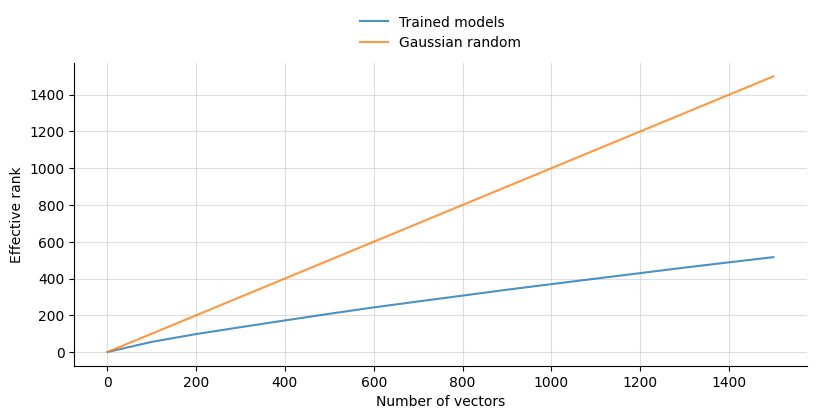

In [13]:
# batch size 
bs = 32
erank_df = create_model_erank_df(grad_bs_dict[bs], device=gpu_id, model_steps=100)
f = plot_models_erank(erank_df)

In [15]:
erank_df

,Trained models,Gaussian random
Number of Vectors,,
1,1.000000,1.000000
101,56.156715,100.995026
201,98.516891,200.981155
301,135.893555,300.957245
401,172.616699,400.924225
501,208.766327,500.881775
601,243.350555,600.830017
701,275.737854,700.769104
801,307.423920,800.697998


## Intersection over Union

In [7]:
# bs128 = grad_bs_dict[128]
# bs128.shape

torch.Size([375, 266610])

In [10]:
frac_prune = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]

In [15]:
prune_results = {}
for fp in frac_prune:
    prune_results[fp] = magnitude_prune_vectors(grad_bs_dict[256], fp)
    iou = intersectionOverUnion(prune_results[fp][1])
    print(f'IoU: {iou}')

IoU: 0.3243734538555145
IoU: 0.18130020797252655
IoU: 0.12902122735977173
IoU: 0.09989091008901596
IoU: 0.07492632418870926
IoU: 0.06038680672645569
IoU: 0.04713523015379906


In [10]:
pv, pm, ts = prune_results[0.2]

In [11]:
ts.max(), ts.min()

(tensor(0.0006, device='cuda:3'), tensor(0.0003, device='cuda:3'))

In [12]:
pm

tensor([[False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:3')

In [13]:
intersectionOverUnion(pm)

0.04699151590466499